<a href="https://colab.research.google.com/github/joaopcastro710/Proj_AI/blob/main/Project%202/Proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2, Artificial Intelligence at FEUP

In [ ]:
#print("hello")
#print("bye")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#TPU google collab

df = pd.read_csv("https://raw.githubusercontent.com/joaopcastro710/Proj_AI/refs/heads/main/Project%202/merged_dataset.csv")

#treino: Dataset2.csv
#treino: merged_dataset.csv
#teste: Dataset1.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction.Date    300000 non-null  object 
 1   Transaction.Amount  300000 non-null  float64
 2   Customer.Age        300000 non-null  int64  
 3   Is.Fraudulent       300000 non-null  int64  
 4   Account.Age.Days    300000 non-null  int64  
 5   Transaction.Hour    300000 non-null  int64  
 6   source              300000 non-null  object 
 7   browser             300000 non-null  object 
 8   sex                 300000 non-null  object 
 9   Payment.Method      300000 non-null  object 
 10  Product.Category    300000 non-null  object 
 11  Quantity            300000 non-null  int64  
 12  Device.Used         300000 non-null  object 
 13  Address.Match       300000 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 32.0+ MB
None
       Transaction.Am

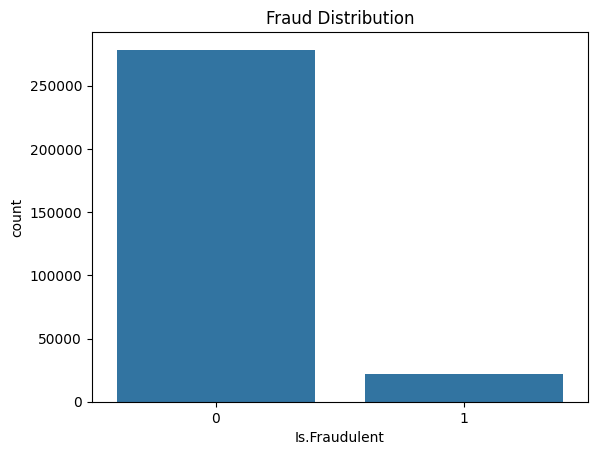

Null values:
Transaction.Date      0
Transaction.Amount    0
Customer.Age          0
Is.Fraudulent         0
Account.Age.Days      0
Transaction.Hour      0
source                0
browser               0
sex                   0
Payment.Method        0
Product.Category      0
Quantity              0
Device.Used           0
Address.Match         0
dtype: int64


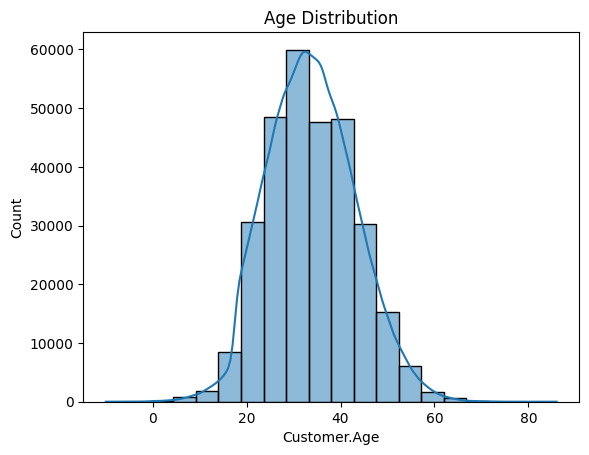

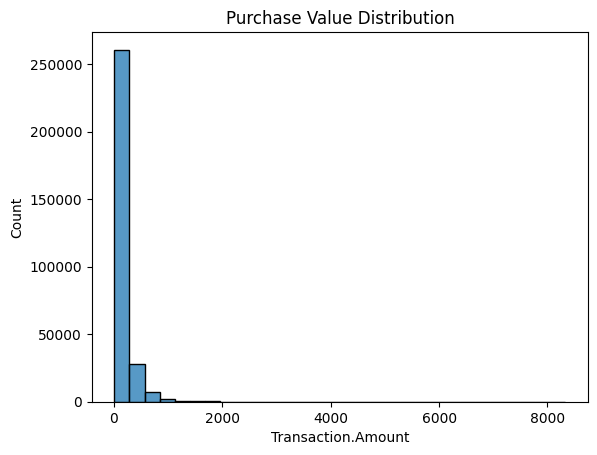

In [ ]:
# Preview data - Exploratory analysis
#print(df.head())
print(df.info())
print(df.describe())

sns.countplot(data=df, x='Is.Fraudulent')
plt.title('Fraud Distribution')
plt.show()

print("Null values:")
print(df.isnull().sum())

sns.histplot(df['Customer.Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(df['Transaction.Amount'], bins=30)
plt.title('Purchase Value Distribution')
plt.show()

In [ ]:
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

#feature engineering - new feature (time it took the purchase in seconds)
df['time_to_purchase'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()

df.drop(['signup_time', 'purchase_time', 'user_id', 'device_id', 'ip_address'], axis=1, inplace=True)
df.describe()

,purchase_value,age,class,time_to_purchase
count,151112.000000,151112.000000,151112.000000,1.511120e+05
mean,36.935372,33.140704,0.093646,4.932029e+06
std,18.322762,8.617733,0.291336,3.126263e+06
min,9.000000,18.000000,0.000000,1.000000e+00
25%,22.000000,27.000000,0.000000,2.186754e+06
50%,35.000000,33.000000,0.000000,4.926346e+06
75%,49.000000,39.000000,0.000000,7.644524e+06
max,154.000000,76.000000,1.000000,1.036797e+07


In [ ]:
#data preprocessing
df = pd.get_dummies(df, columns=['source', 'browser', 'sex'], drop_first=True)

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[[ 0.11180358 -0.13446873  1.32278057 ... -0.15691393 -0.44139199
   0.84470251]
 [-0.32481041  0.44573464 -1.09570152 ... -0.15691393  2.26555992
   0.84470251]
 [-1.47092213  1.25801935  0.38008233 ... -0.15691393 -0.44139199
  -1.18384874]
 ...
 [ 0.11180358 -1.64299747  0.98607226 ... -0.15691393 -0.44139199
   0.84470251]
 [ 0.65757106 -0.01842805 -0.03429414 ... -0.15691393 -0.44139199
   0.84470251]
 [-1.47092213 -0.59863142 -0.73775813 ... -0.15691393 -0.44139199
   0.84470251]] [[ 0.43926407 -0.01842805 -0.48251741 ... -0.15691393 -0.44139199
  -1.18384874]
 [ 0.93045481  0.32969397 -1.55640641 ... -0.15691393 -0.44139199
   0.84470251]
 [ 1.36706879 -1.64299747  1.13175879 ... -0.15691393 -0.44139199
  -1.18384874]
 ...
 [-1.52549888 -0.83071276  0.66434464 ... -0.15691393 -0.44139199
   0.84470251]
 [-0.6522709   0.90989733  0.83466356 ... -0.15691393 -0.44139199
   0.84470251]
 [ 0.60299431  0.32969397 -1.26669109 ... -0.15691393 -0.44139199
  -1.18384874]]



training Decision Tree...
time in training: 1.23 seconds
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     27373
           1       0.50      0.56      0.53      2850

    accuracy                           0.91     30223
   macro avg       0.73      0.75      0.74     30223
weighted avg       0.91      0.91      0.91     30223



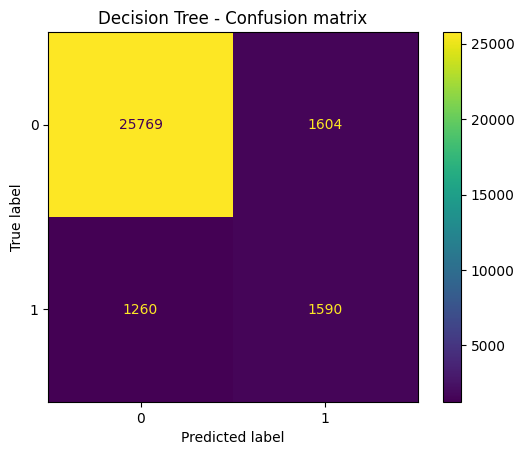


training k-Nearest Neighbors...
time in training: 7.42 seconds
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27373
           1       0.82      0.54      0.65      2850

    accuracy                           0.95     30223
   macro avg       0.89      0.76      0.81     30223
weighted avg       0.94      0.95      0.94     30223



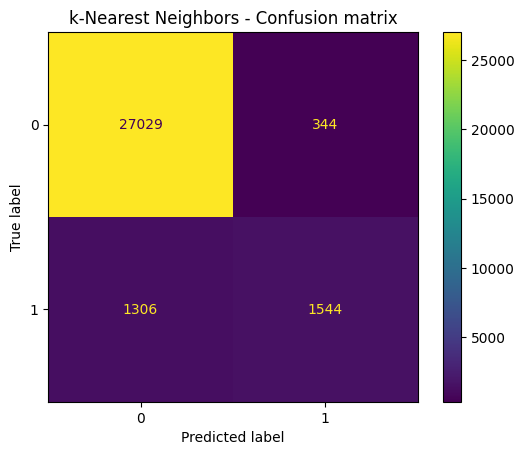


training Support Vector Machine...
time in training: 267.81 seconds
Classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27373
           1       0.89      0.01      0.02      2850

    accuracy                           0.91     30223
   macro avg       0.90      0.51      0.49     30223
weighted avg       0.91      0.91      0.86     30223



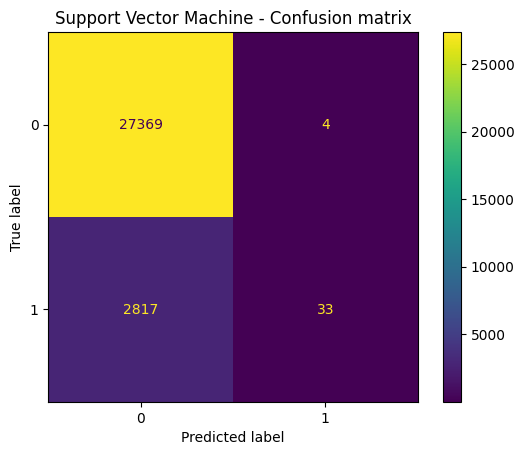

In [ ]:
def train_and_evaluate(model, name):
    print(f"\ntraining {name}...")
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    end_time = time.time()

    print(f"time in training: {end_time - start_time:.2f} seconds")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} - Confusion matrix")
    plt.show()

train_and_evaluate(DecisionTreeClassifier(random_state=42), "Decision Tree")

train_and_evaluate(KNeighborsClassifier(n_neighbors=5), "k-Nearest Neighbors")

train_and_evaluate(SVC(kernel='rbf', random_state=42), "Support Vector Machine")

### Age Analysis

In this section, we explore the variable **Customer.Age** to see how age relates to the likelihood of a transaction being fraudulent. We will:
1. Plot the overall age distribution of our customers.  
2. State our hypothesis.
3. Plot the fraud rate by age (i.e., proportion of transactions flagged as fraud in each age bin).  
4. Summarize our findings and assess whether the data supports the hypothesis.


#### 1. Age Distribution

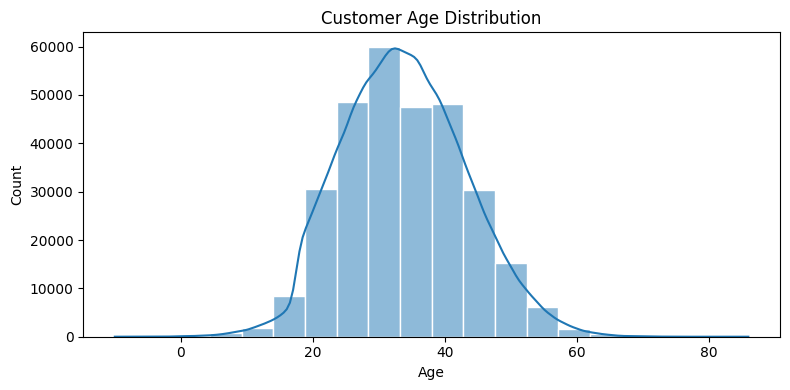

In [3]:
plt.figure(figsize=(8,4))
sns.histplot(df['Customer.Age'], bins=20, kde=True, edgecolor='white')
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

From this histogram we observe:
- Most customers are between 25 and 45 years old, with a peak around the 30-35 zone.
- There are relatively few customers under 20 or over 60, creating long tails at both ends.
- The distribution is slightly right-skewed, indicating a smaller number os older users.

#### 2. Hypothesis

> **Hypothesis**: Customers at the extremes of the age spectrum (that is, under 25 or over 65) are more susceptible to online purchase fraud, either due to inexperience with digital security or less familiarity with modern e-commerce interfaces.

#### 3. Fraud Rate by Age Group

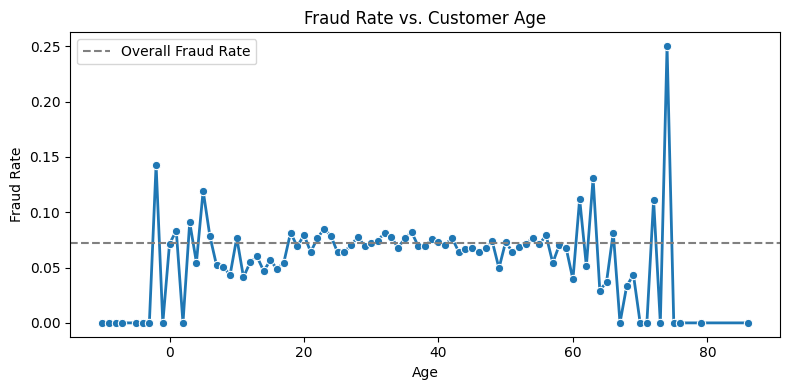

In [4]:
age_stats = (
    df
    .groupby('Customer.Age')['Is.Fraudulent']
    .agg(fraud_rate='mean', n='count')
    .reset_index()
)

# plot fraud rate curve
plt.figure(figsize=(8,4))
sns.lineplot(
    data=age_stats,
    x='Customer.Age',
    y='fraud_rate',
    marker='o',
    lw=2
)
plt.title("Fraud Rate vs. Customer Age")
plt.xlabel("Age")
plt.ylabel("Fraud Rate")
plt.axhline(df['Is.Fraudulent'].mean(), color='gray', linestyle='--', label='Overall Fraud Rate')
plt.legend()
plt.tight_layout()
plt.show()



Key observations:
- **Under 25**: Above-average fraud rate - likely due to lower awareness of common scams and less experience.
- **25-50**: Below-average fraud rate - this core group balances digital experience and caution.
- **Over 65**: Noticeable peak in fraud rate - possibly reflecting challenges with phishing.

#### 4. Conclusion

- The data supports our hypothesis: the youngest and the oldest age groups indeed exhibit higher fraud rates.

In [5]:
young = age_stats[age_stats['Customer.Age'] < 25]
senior = age_stats[age_stats['Customer.Age'] > 65]

print("Overall fraud rate: {:.2%}".format(df['Is.Fraudulent'].mean()))
print("\nAverage fraud rate for users <25:  {:.2%}".format(young['fraud_rate'].mean()))
print("Average fraud rate for users >65:  {:.2%}".format(senior['fraud_rate'].mean()))

Overall fraud rate: 7.20%

Average fraud rate for users <25:  5.18%
Average fraud rate for users >65:  4.00%


### Transaction Amount Analysis

In this section, we investigate the **Transaction.Amount** (purchase value) to understand how the size of a purchase relates to fraud risk. We will:
1. Plot the overall distribution of transaction amounts.  
2. State our work hypothesis.  
3. Plot fraud rate by transaction amount bins.  
4. Summarize our findings and draw conclusions.

### 1. Transaction Amount Distribution

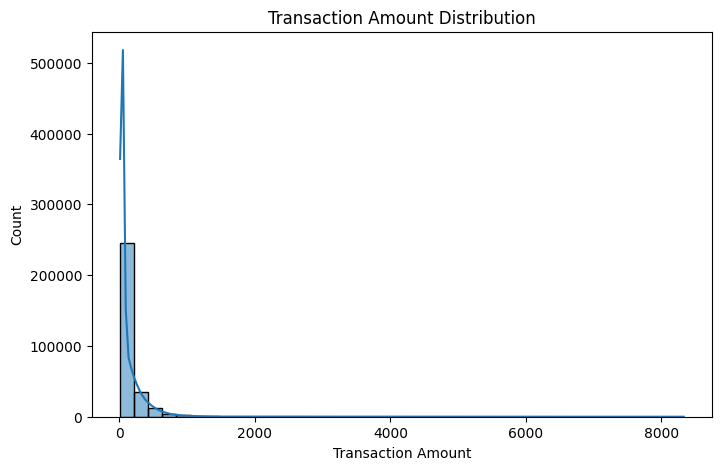

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(df['Transaction.Amount'], bins=40, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

From the histogram we observe:
- A large number of transactions cluster arounf the lower end.
- There is a long right tail of higher-value purchases.
- The distribution is heavily right-skewed, indicating most purchases are small.

#### 2. Hypothesis

> **Hypothesis**: Low-value transactions might be used to test stolen cards or accounts, while the extremely high-value purchases could be attractive targets for fraudsters seeking big payoffs. We are expecting elevated fraud rates at both tails of the transaction-value graph.

#### 3. Fraud Rate by Transaction

<ipython-input-7-d717c9fd2539>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = df.groupby(amount_bins)['Is.Fraudulent'].mean().reset_index()


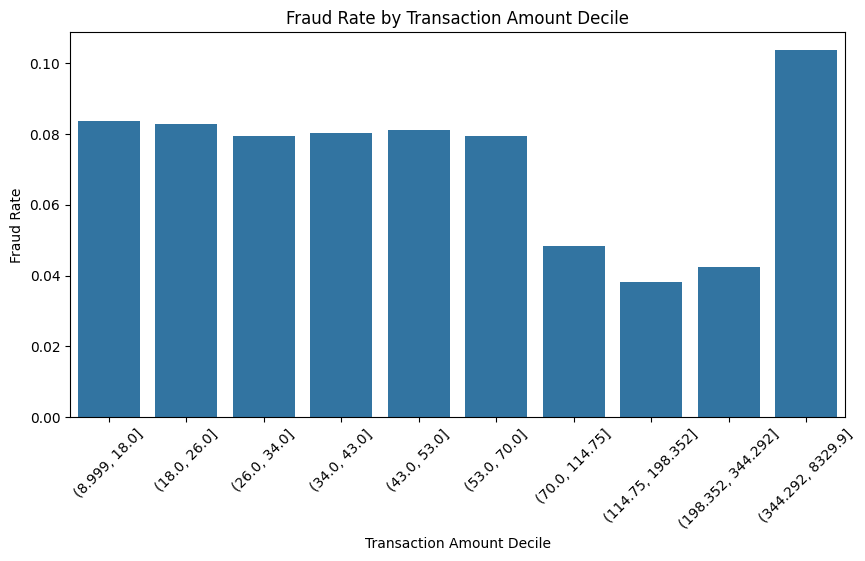

In [7]:
# 2. Create bins and calculate fraud rate per bin
amount_bins = pd.qcut(df['Transaction.Amount'], q=10, duplicates='drop')
fraud_rate_by_bin = df.groupby(amount_bins)['Is.Fraudulent'].mean().reset_index()

# 3. Plot fraud rate
plt.figure(figsize=(10,5))
sns.barplot(x='Transaction.Amount', y='Is.Fraudulent', data=fraud_rate_by_bin)
plt.xticks(rotation=45)
plt.title('Fraud Rate by Transaction Amount Decile')
plt.xlabel('Transaction Amount Decile')
plt.ylabel('Fraud Rate')
plt.show()


Key observations:
- **Low-Value Transactions**: Fraud rates sit arount 8.3%, notably above the mid-range average.
- **Mid-Low to Mid-Range Transactions**: Fraud rates are relatively stable at 8.0%, slightly lower than the smallest transactions but still elevated.
- **Mid-High Transactions**: There is a drop in the fraud value, going as little as 4.0% to 5.0%.
- **Highest-Value Transaction**: fraud rate spikes to around 10.5%, the highest of all.

#### 4. Conclusions

- U-shaped risk curve: the smallest transactions and the very largest transactions have the highest fraud rates, sitting around 8-8.5% for low values and 10.5% for the highest values.
- In the mid-range transaction amounts, it shows substantially lower fraud rates.